# Imports

In [ ]:
from numpy import array, arange, zeros, transpose, cos, sin, arange
from matplotlib import pyplot, rc
from matplotlib.ticker import MultipleLocator
from math import pi
import pandas as pd
from IPython.display import HTML
import base64, pathlib

# The System Models
The following differential equations represent the velocity dynamics of the two DC motors attached to Romi's wheels. The inputs $u_L$ and $u_R$ are the left and right motor voltages which, through the motor dynamics, cause the velocities $\Omega_L$ and $\Omega_R$ to be produced.

$$
\begin{array}{rl}
\frac{d\Omega_L}{dt}      &= \frac{K}{\tau} u_L   - \frac{1}{\tau} \Omega_L \\[6pt]
\frac{d\Omega_R}{dt}      &= \frac{K}{\tau} u_R   - \frac{1}{\tau} \Omega_R
\end{array}
$$

It is important to note that the positive direction for rotation is defined as the direction of rotation that will result in Romi moving forward. This means that the wheels, in which are mounted in opposite directions, will rotate in a complementary manner such that when $\Omega_L$ and $\Omega_R$ are equal and positive, Romi will move forward without rotation (assuming rolling without slip). 

The following differential equations represent the state dynamics of Romi through global space $X_R$ and $Y_R$. The heading angle, $\psi_R$, is defined as the angle made between the global axis $X_R$'s unit vector and the heading direction of Romi. Finally, $s$ is defined as the arc length as seen from the Romi's perspective. This can be thought of as the "odometer" reading of Romi. The motion of the Romi is driven by the wheel angular velocities $\Omega_L$ and $\Omega_R$ as derived above. There is an implicit assumption that Romi rolls without slip. The full derivation for the following differential equations are provided in "Homework 0x03: System Modeling".

$$
\begin{array}{rl}
\frac{dX_R}{dt}      &= \frac{r}{2} cos(\psi_R) (\Omega_R + \Omega_L) \\[6pt]
\frac{dY_R}{dt}      &= \frac{r}{2} sin(\psi_R) (\Omega_R + \Omega_L) \\[6pt]
\frac{d\psi_R}{dt}   &= \frac{r}{w} (\Omega_R - \Omega_L)    \\[6pt]
\frac{ds}{dt}        &= \frac{r}{2} (\Omega_R + \Omega_L)    \\[6pt]
\end{array}
$$

Where $r$ is the radius of the wheels and $w$ is the track width (distance between wheel centers) of Romi. The preceding equations can be combined into a single vector equation so that we can solve it using vector based ODE solution techniques.

$$
\begin{array}{rcl}
\dot{\mathbf{x}}
&=
\frac{d}{dt}
    \begin{bmatrix}
        X_R      \\[6pt]
        Y_R      \\[6pt]
        \psi_R   \\[6pt]
        s        \\[6pt]
        \Omega_L \\[6pt]
        \Omega_R \\[6pt]
    \end{bmatrix}
&=
\begin{bmatrix}
    \frac{r}{2} cos(\psi_R) (\Omega_R + \Omega_L) \\[6pt]
    \frac{r}{2} sin(\psi_R) (\Omega_R + \Omega_L) \\[6pt]
    \frac{r}{w} (\Omega_R - \Omega_L)    \\[6pt]
    \frac{r}{2} (\Omega_R + \Omega_L)    \\[6pt]
    \frac{K}{\tau} u_L   - \frac{1}{\tau} \Omega_L \\[6pt]
    \frac{K}{\tau} u_R   - \frac{1}{\tau} \Omega_R \\[6pt]
\end{bmatrix}
\end{array}
$$

The preceding sytem of equations are of the form $\dot{\mathbf{x}} = \mathbf{f}\left(t, \mathbf{x}\right)$ which is the standard form for nonlinear state-space systems. This system of equations represent the dynamics of the entire system; that is, all of the differential equations are wrapped up in one large matrix equation.

It is often the case that outputs of interest are not present in the state vector directly. In such instances a second set of equations is utilized to select outputs of interest in the form $\mathbf{y} = \mathbf{g}\left(t, \mathbf{x}\right)$. For the Romi model, the desired outputs will include the four orientational state variables $X_R$, $Y_R$, $\psi_R$, and $s$ as well as the velocity of Romi, $v$ and the yaw rate of Romi, $\Omega$.

$$
\begin{array}{rcl}
\mathbf{y}
&=
\begin{bmatrix}
        X_R      \\[6pt]
        Y_R      \\[6pt]
        \psi_R   \\[6pt]
        s        \\[6pt]
        v        \\[6pt]
        \Omega \\[6pt]
\end{bmatrix}
&=
\begin{bmatrix}
    X_R     \\[6pt]
    Y_R     \\[6pt]
    \psi_R  \\[6pt]
    s       \\[6pt]
    \frac{r}{2} (\Omega_R + \Omega_L)    \\[6pt]
    \frac{r}{w} (\Omega_R - \Omega_L)    \\[6pt]
\end{bmatrix}
\end{array}
$$

In the code below, there are two different functions defined; each one implements both the state equations, $\dot{\mathbf{x}} = \mathbf{f}\left(t, \mathbf{x}\right)$, and the output equations, $\mathbf{y} = \mathbf{g}\left(t, \mathbf{x}\right)$ as shown above. The difference between the two functions is that the first implements an open-loop simulation and the second implements a closed loop simulation.

That is, the first function uses constant supply voltages of $u_L$ and $u_R$ that are calculated. They are calculated by determining the steady state velocity needed of $\Omega_L$ and $\Omega_R$ to obtain a circle of a certain radius, $r_turn$ at a specified Romi velocity, $v$. The second function also approaches these calculated $\Omega_L$ and $\Omega_R$ but using a PID controller, which monitors each of Romi's wheels and applies the feedback law to adjust the $u_L$ and $u_R$ to achieve the desired $\Omega_L$ and $\Omega_R$ quicker. The PID controller is implemented as seen in the figure below.





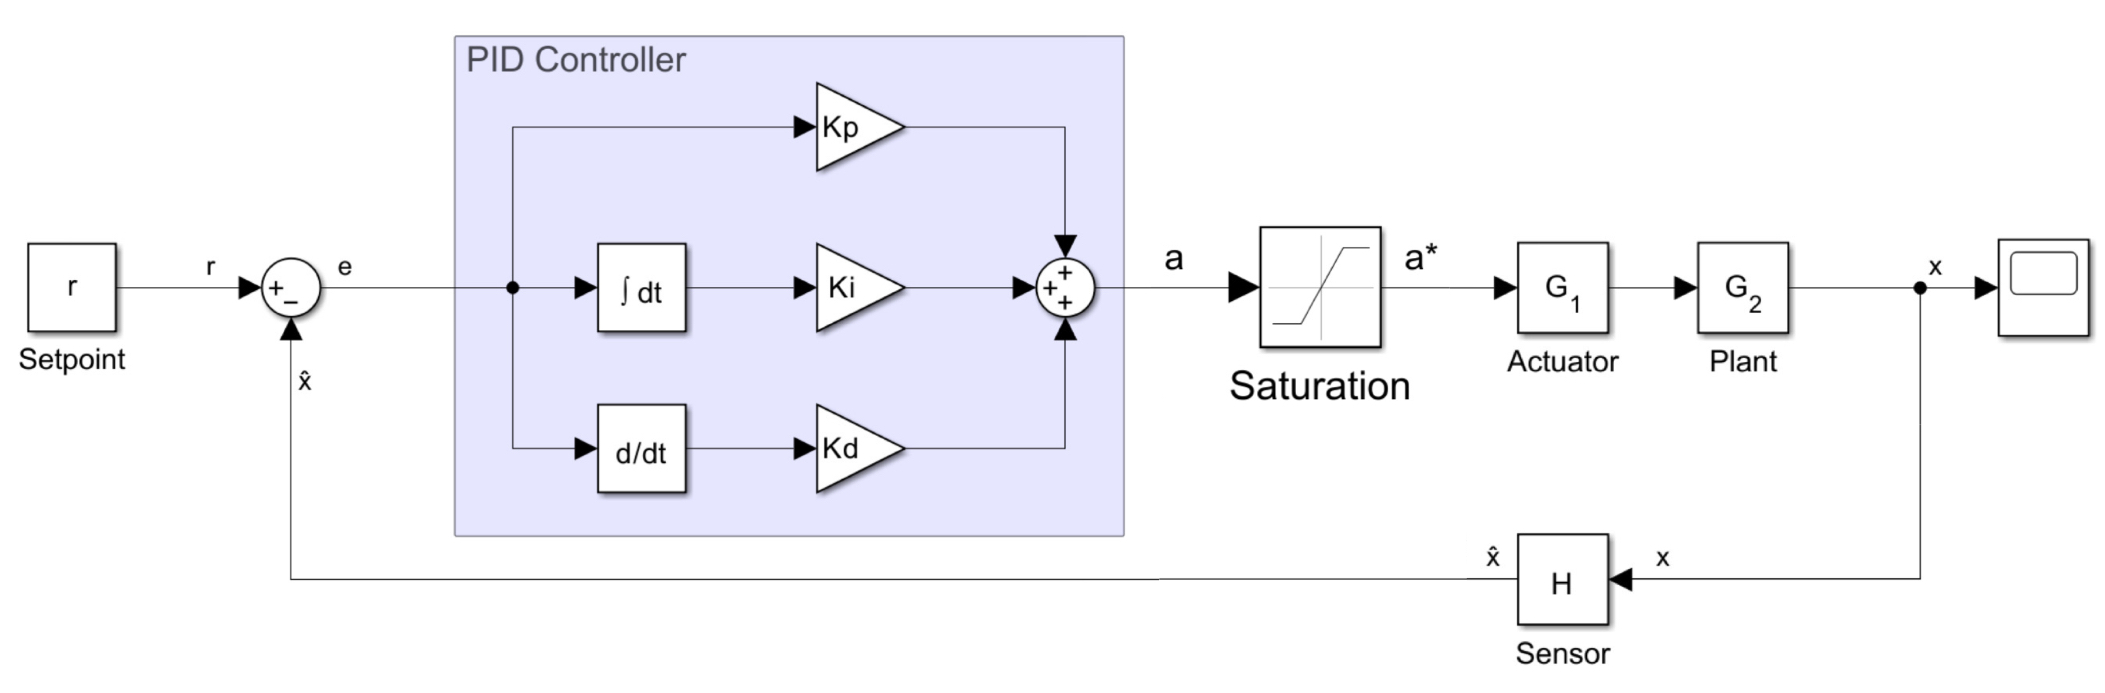

In [ ]:
# I am hoping this will work for the grader to see, since the other methods require relative pathing to a photo
# Since we are only submitting one file, I didn't think those approaches would work. If it does not render, the photo
# is the PID controller from "Lab 0x03 Closed Loop Control" with an added saturation block after the controller.
p = pathlib.Path("image0.jpeg")
b64 = base64.b64encode(p.read_bytes()).decode()
HTML(f'<img src="data:image/jpeg;base64,{b64}" width="1600">')

## Model Parameters
The following is a table of the the estimated model parameters required to accomplish the simulation. The values are to be updated as the quarter progresses.

In [ ]:
# Electromechanical properties
K      = 250*2*pi/60/4.5     # Motor Gain [rad/(V*s)]
tau    = 0.1                 # Motor Time Constant [s]

# Mechanical properties
r_wheel       = 35                 # Wheel Radii [mm]
w_track       = 141                # Track Width [mm]

params = pd.DataFrame({
    "Parameter": ["Motor Gain", "Motor Time Constant", "Wheel Radius", "Track Width"],
    "Value": [K, tau, r_wheel, w_track],
    "Units": ["rad/(V*s)", "s", "mm", "mm"],
})
params.style.format({"Value": "{:.2f}"}).set_table_attributes('style="margin-left:auto; margin-right:auto;"').set_properties(**{"text-align": "center"}).set_table_styles([{"selector": "th.col_heading", "props": [("text-align", "center")]}]) # type: ignore

,Parameter,Value,Units
0,Motor Gain,5.82,rad/(V*s)
1,Motor Time Constant,0.10,s
2,Wheel Radius,35.00,mm
3,Track Width,141.00,mm


## Open Loop System Model

In [ ]:
def system_eqn_OL(t, x, Omega_L_REF, Omega_R_REF, DONOTUSE):
    '''!@brief      Implements both state equations and output equations for the
                    open loop system
        @param t    The value of time for a given simulation step
        @param x    The value of the state vector for a given simulation step
        @return     A tuple containing both the derivative of the state vector
                    and the output vector for a given simulation step
    '''

    
    # Open-loop inputs
    u = array([ [ Omega_L_REF/K ],    # u_L
                [ Omega_R_REF/K ] ])  # u_R
        
    # State equations
    xd =  array( [  [ (r_wheel/2)*cos(x[2,0])*(x[5,0] + x[4,0]) ],    # X-dot_R     = r/2*cos(psi)*(Omega_R + Omega_L)
                    [ (r_wheel/2)*sin(x[2,0])*(x[5,0] + x[4,0]) ],    # Y-dot_R     = r/2*sin(psi)*(Omega_R + Omega_L)
                    [ (r_wheel/w_track)*(x[5,0] - x[4,0]) ],          # Psi-dot_R   = r/w*(Omega_R - Omega_L)       
                    [ (r_wheel/2)*(x[5,0] + x[4,0]) ],                # s-dot       = r/2*(Omega_R + Omega_L)
                    [ K/tau*u[0,0] - 1/tau*x[4,0] ],                  # Omega-dot_L = (K/tau)*u_L - (1/tau)*Omega_L
                    [ K/tau*u[1,0] - 1/tau*x[5,0] ],])                # Omega-dot_R = (K/tau)*u_R - (1/tau)*Omega_R
    
    # Output Equations
    y  =  array( [ [ x[0,0] ],                                 # X_R
                   [ x[1,0] ],                                 # Y_R    
                   [ x[2,0] ],                                 # Psi_R
                   [ x[3,0] ],                                 # s
                   [ (r_wheel/2)*(x[5,0] + x[4,0]) ],          # v = s-dot
                   [ (r_wheel/w_track)*(x[5,0] - x[4,0]) ]])   # Omega_ROMI = psi-dot    
    
    # # modified output equations to see wheel angular velocities
    # y  =  array( [ [ x[0,0] ],                                 # X_R
    #                [ x[1,0] ],                                 # Y_R    
    #                [ x[2,0] ],                                 # Psi_R
    #                [ x[3,0] ],                                 # s
    #                [ (r_wheel/2)*(x[5,0] + x[4,0]) ],          # v = s-dot
    #                [ (r_wheel/w_track)*(x[5,0] - x[4,0]) ],    # Omega_ROMI = psi-dot
    #                [ x[4,0] ],                                 # Omega_L    
    #                [ x[5,0] ],])                               # Omega_R   

    return xd, y, None 

## Closed Loop System Model

In [ ]:
def system_eqn_CL(t, x, Omega_L_REF, Omega_R_REF, CLC_vals):
    '''!@brief      Implements both state equations and output equations for
                    the open loop system
        @param t    The value of time for a given simulation step
        @param x    The value of the state vector for a given simulation step
        @param v    The value of the input velocity magnitude for a given simulation step
        @param r    The value of the circlr  for a given simulation step
        @return     A tuple containing both the derivative of the state vector
                    and the output vector for a given simulation step
    '''
    
    # Unpack CLC values
    dt, integral_L, integral_R, prev_error_L, prev_error_R = CLC_vals[:5]

    # Closed Loop Gains (Same for both motors)
    Kp = 30 # Proportional Gain
    Ki = 30 # Integral Gain
    Kd = 0.06 # Derivative Gain

    # # Get errors
    e_L = Omega_L_REF - x[4,0] # Error = Omega_L_REF - Omega_L_meas
    e_R = Omega_R_REF - x[5,0] # Error = Omega_R_REF - Omega_R_meas

    # get proortional gains
    a_L_p = Kp*e_L
    a_R_p = Kp*e_R

    # get integral and derivative gains (if not first step) then get actuation values
    if t != 0:
        # integral
        integral_L += e_L*dt
        integral_R += e_R*dt
        a_L_i = Ki*integral_L
        a_R_i = Ki*integral_R
        
        # derivative
        a_L_d = Kd*(e_L - prev_error_L)/dt
        a_R_d = Kd*(e_R - prev_error_R)/dt
        prev_error_L = e_L
        prev_error_R = e_R

        # add gains
        a_L = a_L_p + a_L_i + a_L_d
        a_R = a_R_p + a_R_i + a_R_d
    else:
        a_L = a_L_p
        a_R = a_R_p

    # saturate actuation values
    a_L = max(min(a_L, 10), -10)
    a_R = max(min(a_R, 10), -10)
    
    # set new CLC values for next iteration
    New_CLC_vals = [dt, integral_L, integral_R, prev_error_L, prev_error_R]

    # State equations
    xd =  array( [  [ (r_wheel/2)*cos(x[2,0])*(x[5,0] + x[4,0]) ],    # X-dot_R     = r/2*cos(psi)*(Omega_R + Omega_L)
                    [ (r_wheel/2)*sin(x[2,0])*(x[5,0] + x[4,0]) ],    # Y-dot_R     = r/2*sin(psi)*(Omega_R + Omega_L)
                    [ (r_wheel/w_track)*(x[5,0] - x[4,0]) ],          # Psi-dot_R   = r/w*(Omega_R - Omega_L)       
                    [ (r_wheel/2)*(x[5,0] + x[4,0]) ],                # s-dot       = r/2*(Omega_R + Omega_L)
                    [ K/tau*a_L - 1/tau*x[4,0] ],                  # Omega-dot_L = (K/tau)*u_L - (1/tau)*Omega_L
                    [ K/tau*a_R - 1/tau*x[5,0] ],])                # Omega-dot_R = (K/tau)*u_R - (1/tau)*Omega_R
    
    # Output Equations
    y  =  array( [ [ x[0,0] ],                                 # X_R
                   [ x[1,0] ],                                 # Y_R    
                   [ x[2,0] ],                                 # Psi_R
                   [ x[3,0] ],                                 # s
                   [ (r_wheel/2)*(x[5,0] + x[4,0]) ],          # v = s-dot
                   [ (r_wheel/w_track)*(x[5,0] - x[4,0]) ]])   # Omega_ROMI = psi-dot    
    

    # # modified output equations to see wheel angular velocities
    # y  =  array( [ [ x[0,0] ],                                 # X_R
    #                [ x[1,0] ],                                 # Y_R    
    #                [ x[2,0] ],                                 # Psi_R
    #                [ x[3,0] ],                                 # s
    #                [ (r_wheel/2)*(x[5,0] + x[4,0]) ],          # v = s-dot
    #                [ (r_wheel/w_track)*(x[5,0] - x[4,0]) ],    # Omega_ROMI = psi-dot
    #                [ x[4,0] ],                                 # Omega_L    
    #                [ x[5,0] ],])                               # Omega_R 
    
    return xd, y, New_CLC_vals

# Solvers

## Forward Euler Solver
For this example, as provided a simple solver will be implemented for you. That is, a first-order forward Euler solver is implemented below. It can be used as a template or example that you may extend to use a higher-order integration method, such as the Runge-Kutta method, see below for additional details.

The details of the solver will not be covered here in great depth, however it is important to understand the integration method in some depth to complete the assignment. The fundamental assumption used in a first-order solver is that over a small window of time the state of the system changes at a constant rate. That is, the derivative of the state vector, $\dot{\mathbf{x}}$, is assumed constant over a short window of time, $\Delta t$. This assumption leads directly to an integration algorithm called Euler's method. There are multiple formulations of Euler's method, and the simplest form is the Forward Euler method. The method predicts future states of the system based on knowledge of the present state and its derivative at a given instant in time. It is called a forward Euler method because it uses information at a given step $n$ to predict the future state at step $n+1$.

$$
\begin{array}{rl}
\frac{\Delta \mathbf{x}}{\Delta t} &= \dot{\mathbf{x}}_n         \\[2pt]
\Delta \mathbf{x} &= \dot{\mathbf{x}}_n \Delta t                 \\[2pt]
\mathbf{x}_{n+1} - \mathbf{x}_{n} &= \dot{\mathbf{x}}_n \Delta t \\[2pt]
\mathbf{x}_{n+1} &= \mathbf{x}_{n} + \dot{\mathbf{x}}_n \Delta t
\end{array}
$$
where, 
$$
\begin{array}{rl}
\dot{\mathbf{x}}_n &= \mathbf{f}(t,\mathbf{x}_n).
\end{array}
$$

In [ ]:
def Euler_solver(fcn, x_0, tspan, tstep, v, r_turn):
    '''!@brief        Implements a first-order forward euler solver
        @param fcn    A function handle to the function to solve
        @param x_0    The initial value of the state vector
        @param tspan  A span of time over which to solve the system specified
                      as a list with two elements representing initial and
                      final time values
        @param tstep  The step size to use for the integration algorithm
        @param v      The magnitude of the input velocity [mm/s] for a given simulation 
        @param r      The radius of circular path [mm] for a given simulation 
        @return       A tuple containing both an array of time values and an
                      array of output values
    '''
    
    # Define a column of time values
    tout = arange(tspan[0], tspan[1]+tstep, tstep)

    # Preallocate an array of zeros to store state values
    xout = zeros([len(tout)+1,len(x_0)])
    
    # Determine the input voltages for both wheels based on target path
    Yaw_rate_nominal = v/r_turn # rad/s
    
    Omega_L_REF = (1/r_wheel)*(v - (Yaw_rate_nominal*w_track)/2) # rad/s
    Omega_R_REF = ((Yaw_rate_nominal*w_track)/r_wheel) + Omega_L_REF # rad/s

    # Determine the dimension of the output vector
    output_dim = len(fcn(0,x_0, Omega_L_REF, Omega_R_REF)[1])

    # Preallocate an array of zeros to store output values
    yout = zeros([len(tout),output_dim])

    # Initialize output array with intial state vector
    xout[0][:] = x_0.T

    # Iterate through the algorithm but stop one cycle early because
    # the algorithm predicts one cycle into the future
    for n in range(len(tout)):
        
        # Pull out a row from the solution array and transpose to get
        # the state vector as a column
        x = xout[[n]].T
        
        # Pull out the present value of time
        t = tout[n]
        
        # Evaluate the function handle at the present time with the
        # present value of the state vector to compute the derivative
        xd, y = fcn(t, x, Omega_L_REF, Omega_R_REF)[:2]
        
        # Apply the update rule for Euler's method. The derivative value
        # must be transposed back to a row here for the dimensions to line up.
        xout[n+1] = xout[n] + xd.T*tstep
        yout[n] = y.T
    
    return tout, yout

## Runge-Kutta Method (4th-order)
The following algorithm is presented without derivation, but is a marked improvement over Euler's method presented above. The integration technique is fourth-order, instead first-order, so has a much smaller truncation error for a given step size. Using an "RK" solver will allow you to use a much more reasonable step size and still get a solution of reasonable accuracy. The algorithm is similar to Euler's method, however it splits the window of time, $\Delta t$, in half and computes the derivative several times at the start of the time window, in the middle, and at the end. These derivatives are used to find a weighted average which is then used in a standard Euler step.
$$
\begin{array}{rl}
\mathbf{x}_{n+1} &= \mathbf{x}_{n} + \frac{1}{6} \left(\mathbf{k}_1 + 2 \mathbf{k}_2 + 2 \mathbf{k}_3 + \mathbf{k}_4 \right) \Delta t
\end{array}
$$
where,
$$
\begin{array}{rll}
\mathbf{k}_1 &= \mathbf{f}(t, & \mathbf{x}_n)                                              \\[4pt]
\mathbf{k}_2 &= \mathbf{f}(t+\frac{1}{2}\Delta t, & \mathbf{x}_n+\frac{1}{2} k_1 \Delta t) \\[4pt]
\mathbf{k}_3 &= \mathbf{f}(t+\frac{1}{2}\Delta t, & \mathbf{x}_n+\frac{1}{2} k_2 \Delta t) \\[4pt]
\mathbf{k}_4 &= \mathbf{f}(t+\Delta t, & \mathbf{x}_n+k_3 \Delta t).
\end{array}
$$

In [ ]:
def RK4_solver(fcn, x_0, tspan, tstep, v, r_turn):
    '''!@brief        Implements a first-order forward euler solver
        @param fcn    A function handle to the function to solve
        @param x_0    The initial value of the state vector
        @param tspan  A span of time over which to solve the system specified
                      as a list with two elements representing initial and
                      final time values
        @param tstep  The step size to use for the integration algorithm
        @param v      The magnitude of the input velocity [mm/s] for a given simulation 
        @param r      The radius of circular path [mm] for a given simulation 
        @return       A tuple containing both an array of time values and an
                      array of output values
    '''
    
    # Define a column of time values
    tout = arange(tspan[0], tspan[1]+tstep, tstep)

    # Preallocate an array of zeros to store state values
    xout = zeros([len(tout)+1,len(x_0)])

    # Create the initial CLC value list
    CLC_vals = [tstep, 0, 0, 0, 0]
    
    # Determine the input voltages for both wheels based on target path
    Yaw_rate_nominal = v/r_turn # rad/s
    
    Omega_L_REF = (1/r_wheel)*(v - (Yaw_rate_nominal*w_track)/2) # rad/s
    Omega_R_REF = ((Yaw_rate_nominal*w_track)/r_wheel) + Omega_L_REF # rad/s
    
    # Determine the dimension of the output vector
    output_dim = len(fcn(0,x_0, Omega_L_REF, Omega_R_REF, CLC_vals)[1])
    
    # Preallocate an array of zeros to store output values
    yout = zeros([len(tout), output_dim])

    # Initialize output array with intial state vector
    xout[0][:] = x_0.T

    # Iterate through the algorithm but stop one cycle early because
    # the algorithm predicts one cycle into the future
    for n in range(len(tout)):
        
        # Pull out a row from the solution array and transpose to get
        # the state vector as a column
        x = xout[[n]].T
        
        # Pull out the present value of time
        t = tout[n]
        
        # Evaluate the function handle at the times outlined in RK4
        # to compute the derivative
        K1_x, K1_y, K1_CLC_vals = fcn(t,           x,                Omega_L_REF, Omega_R_REF, CLC_vals)
        K2_x, K2_y, K2_CLC_vals = fcn(t + tstep/2, x + K1_x*tstep/2, Omega_L_REF, Omega_R_REF, CLC_vals)
        K3_x, K3_y, K3_CLC_vals = fcn(t + tstep/2, x + K2_x*tstep/2, Omega_L_REF, Omega_R_REF, CLC_vals)
        K4_x, K4_y, K4_CLC_vals = fcn(t + tstep,   x + K3_x*tstep,   Omega_L_REF, Omega_R_REF, CLC_vals)
        
        # Compute the update rule for RK4's method
        xout[n+1] = xout[n] + ((1/6)*(K1_x + 2*K2_x + 2*K3_x + K4_x)).T * tstep
        yout[n] = (1/6)*(K1_y + 2*K2_y + 2*K3_y + K4_y).T

        # Update the CLC values (if they exist)
        if CLC_vals is None or K1_CLC_vals is None:
            CLC_vals = None
        else:
            CLC_vals = [(k1 + 2*k2 + 2*k3 + k4)/6.0 for k1, k2, k3, k4 in zip(K1_CLC_vals, K2_CLC_vals, K3_CLC_vals, K4_CLC_vals)]
            # zip(K1_CLC_vals...K4...) --> [(k1_dt, k2_dt, k3_dt, k4_dt), (k1_intL, k2_intL...), ...]
    
    return tout, yout

# Running the Open-Loop Simulation

In [ ]:
# The following initial conditions will be used by both the open-loop and
# closed-loop simulations
x_0 = array([   [0],    # X_R [mm]
                [0],    # Y_R [mm]
                [0],    # Psi_R [rad]
                [0],    # s [mm]
                [0],    # Omega_L [rad/s]
                [0],])  # Omega_R [rad/s]

v_ref = 500  # [mm/s]
r_turn = 250  # [mm]

# Solve the open loop system over a 0.1 second time window with 1 us steps
# t_OL_EUL, y_OL_EUL = Euler_solver(system_eqn_OL, x_0, [0, 1], 1e-6, v_ref, r_turn)

# Solve the open loop system over a 3.25 second time window with 1 ms steps
t_OL_RK4, y_OL_RK4 = RK4_solver(system_eqn_OL, x_0, [0, 3.25], 1e-3, v_ref, r_turn)[:2]

## Plotting the Open-Loop Simulation Results

<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:56: SyntaxWarning: invalid escape sequence '\O'
<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:56: SyntaxWarning: invalid escape sequence '\O'
C:\Users\venti\AppData\Local\Temp\ipykernel_18872\3517200386.py:26: SyntaxWarning: invalid escape sequence '\p'
  pyplot.ylabel('Heading Angle, $\psi_R$ [rad]')
C:\Users\venti\AppData\Local\Temp\ipykernel_18872\3517200386.py:56: SyntaxWarning: invalid escape sequence '\O'
  pyplot.ylabel('Yaw Rate, $\Omega$ [rad/s]')


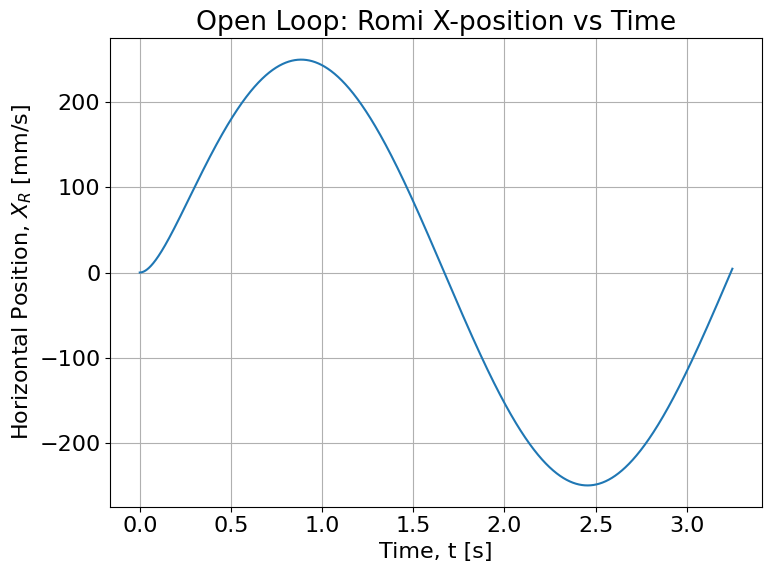

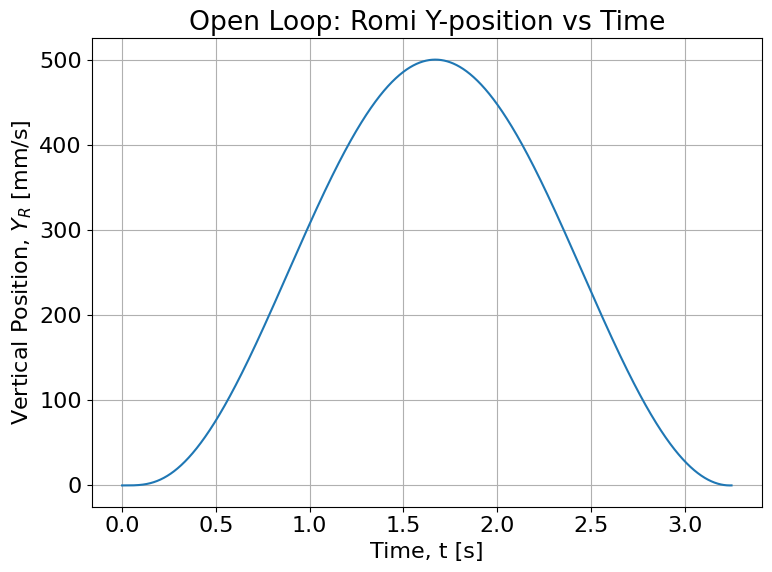

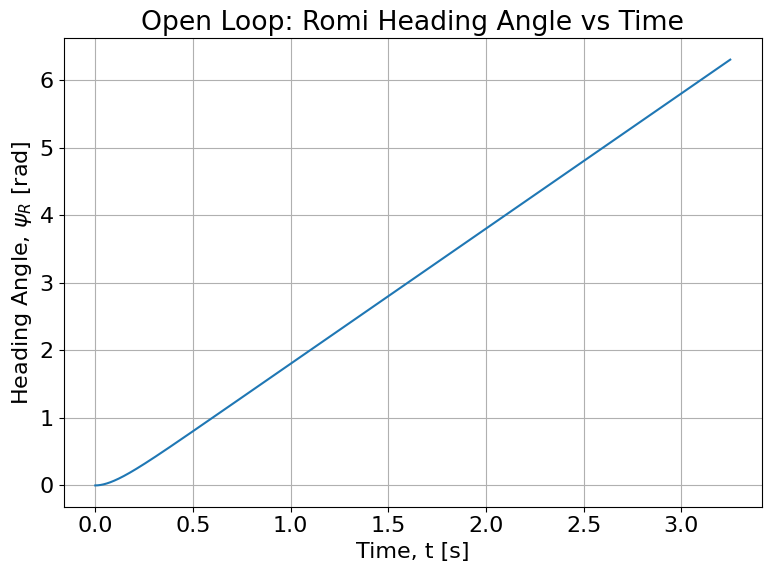

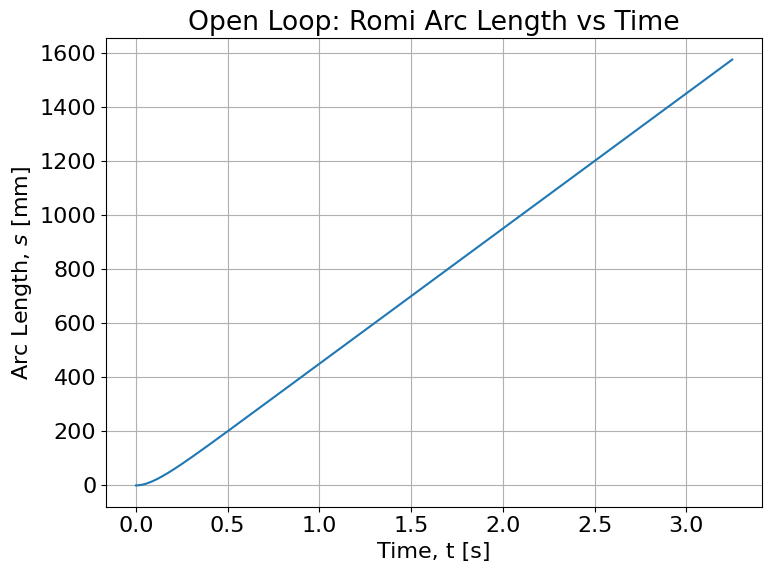

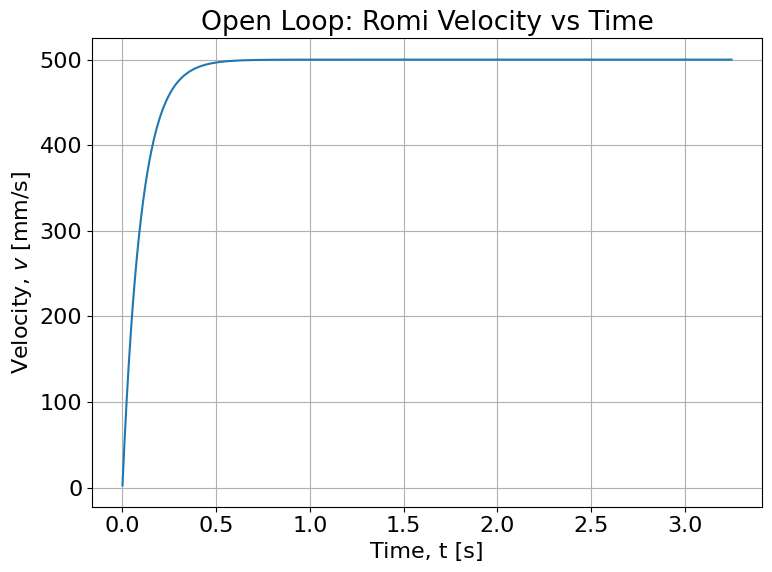

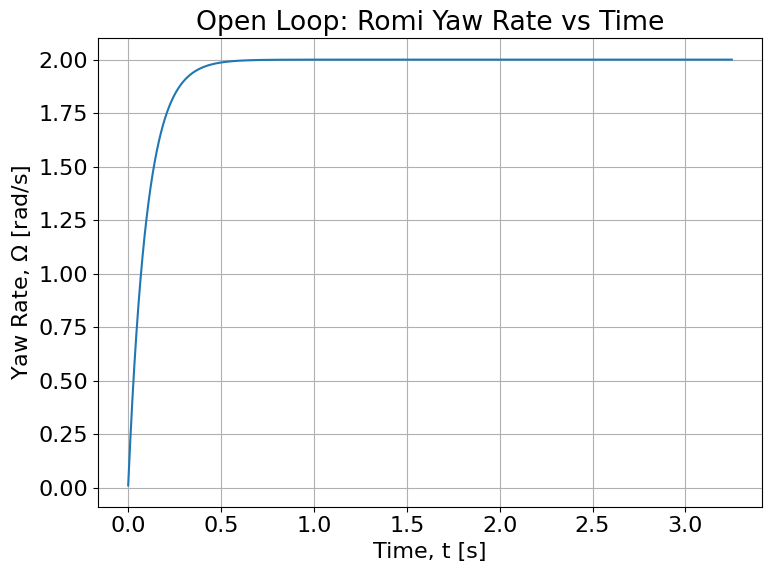

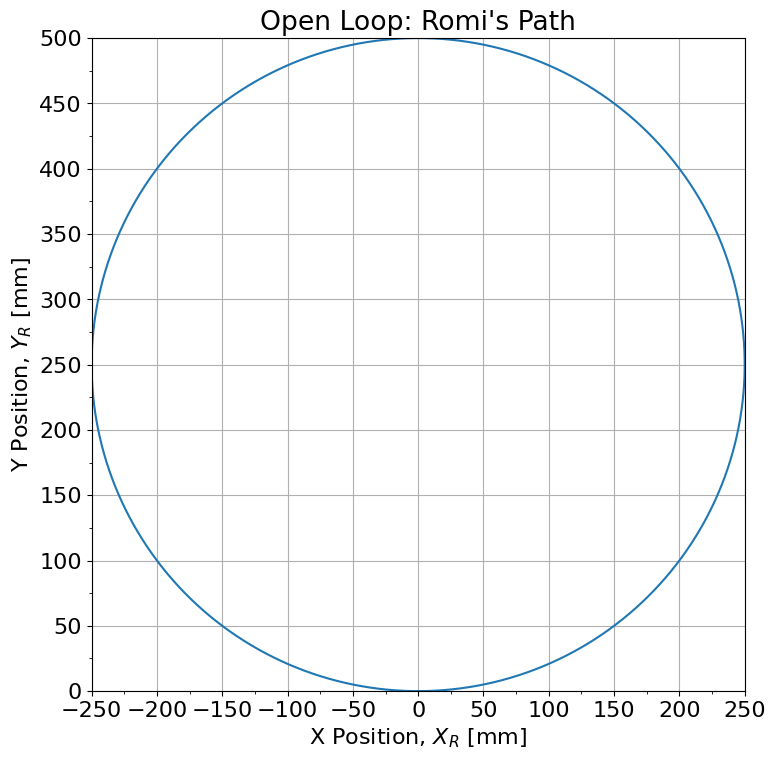

In [ ]:
# ------------- Plot Romi X-position vs time -------------
rc('font', **{'size'   : 16})
pyplot.figure(figsize=(8,6))
pyplot.plot(t_OL_RK4, y_OL_RK4[:,0])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Horizontal Position, $X_R$ [mm/s]')
pyplot.title('Open Loop: Romi X-position vs Time')
pyplot.grid()
pyplot.tight_layout()

# ------------- Plot Romi Y-position vs time -------------
rc('font', **{'size'   : 16})
pyplot.figure(figsize=(8,6))
pyplot.plot(t_OL_RK4, y_OL_RK4[:,1])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Vertical Position, $Y_R$ [mm/s]')
pyplot.title('Open Loop: Romi Y-position vs Time')
pyplot.grid()
pyplot.tight_layout()

# ------------- Plot Romi Heading vs time -------------
rc('font', **{'size'   : 16})
pyplot.figure(figsize=(8,6))
pyplot.plot(t_OL_RK4, y_OL_RK4[:,2])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Heading Angle, $\psi_R$ [rad]')
pyplot.title('Open Loop: Romi Heading Angle vs Time')
pyplot.grid()
pyplot.tight_layout()

# ------------- Plot Romi Arc length vs time -------------
rc('font', **{'size'   : 16})
pyplot.figure(figsize=(8,6))
pyplot.plot(t_OL_RK4, y_OL_RK4[:,3])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Arc Length, $s$ [mm]')
pyplot.title('Open Loop: Romi Arc Length vs Time')
pyplot.grid()
pyplot.tight_layout()

# ------------- Plot Romi Velocity vs time -------------
rc('font', **{'size'   : 16})
pyplot.figure(figsize=(8,6))
pyplot.plot(t_OL_RK4, y_OL_RK4[:,4])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Velocity, $v$ [mm/s]')
pyplot.title('Open Loop: Romi Velocity vs Time')
pyplot.grid()
pyplot.tight_layout()

# ------------- Plot Romi Yaw Rate vs time -------------
rc('font', **{'size'   : 16})
pyplot.figure(figsize=(8,6))
pyplot.plot(t_OL_RK4, y_OL_RK4[:,5])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Yaw Rate, $\Omega$ [rad/s]')
pyplot.title('Open Loop: Romi Yaw Rate vs Time')
pyplot.grid()
pyplot.tight_layout()

# ------------- Plot Romi Path -------------
rc('font', **{'size'   : 16})
pyplot.figure(figsize=(8,8))
pyplot.plot(y_OL_RK4[:,0], y_OL_RK4[:,1])
pyplot.title("Open Loop: Romi's Path")
pyplot.xlabel('X Position, $X_R$ [mm]')
pyplot.ylabel('Y Position, $Y_R$ [mm]')
pyplot.xlim(-250, 250)   
pyplot.ylim(0, 500)  
ax = pyplot.gca()
ax.xaxis.set_major_locator(MultipleLocator(50))  # major ticks every 50 mm
ax.xaxis.set_minor_locator(MultipleLocator(25))  # minor ticks every 25 mm
ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(25))
ax.set_aspect('equal', adjustable='box')   # preserve data aspect
ax.set_box_aspect(1)                       # make the plotting box square
pyplot.grid()
pyplot.tight_layout()


# Running the Closed-Loop Simulation

In [600]:
# Solve the closed loop system over a 4 second time window with pi ms steps
t_CL, y_CL = RK4_solver(system_eqn_CL, x_0, [0, pi], 1e-3, v_ref, r_turn)

## Plotting the Closed-Loop Simulation Results

<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:56: SyntaxWarning: invalid escape sequence '\O'
<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:56: SyntaxWarning: invalid escape sequence '\O'
C:\Users\venti\AppData\Local\Temp\ipykernel_18872\3664432778.py:26: SyntaxWarning: invalid escape sequence '\p'
  pyplot.ylabel('Heading Angle, $\psi_R$ [rad]')
C:\Users\venti\AppData\Local\Temp\ipykernel_18872\3664432778.py:56: SyntaxWarning: invalid escape sequence '\O'
  pyplot.ylabel('Yaw Rate, $\Omega$ [rad/s]')


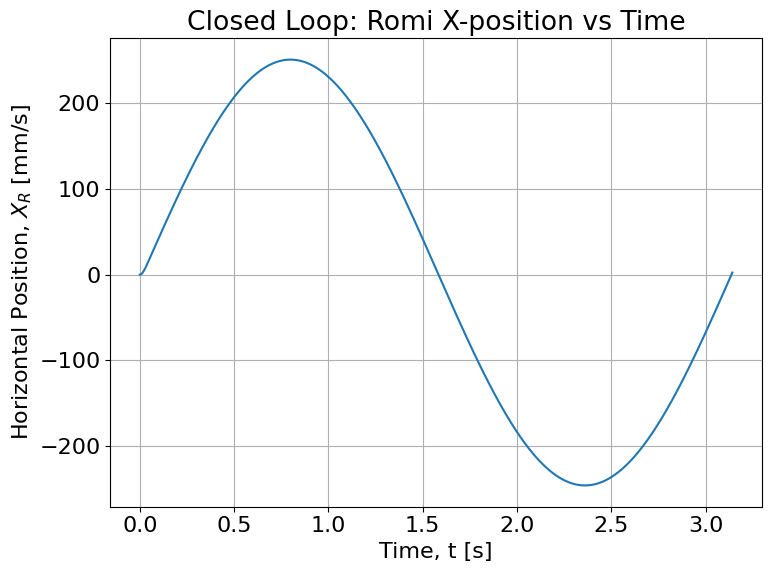

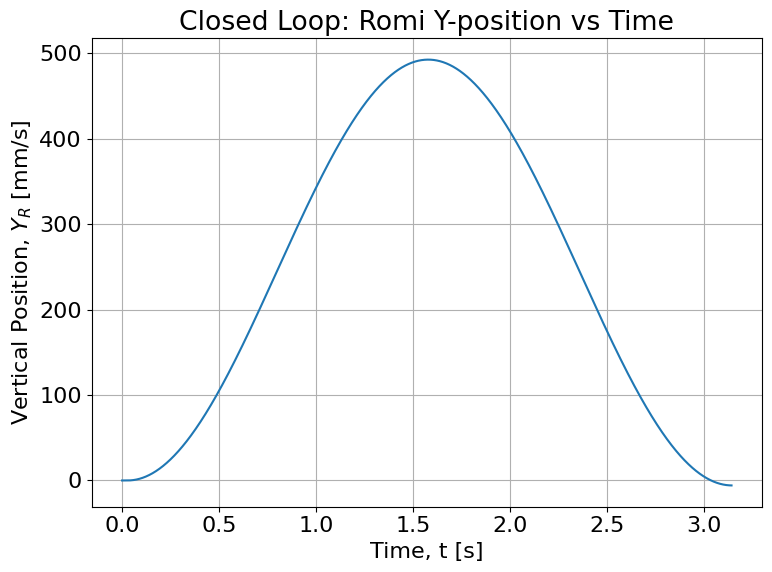

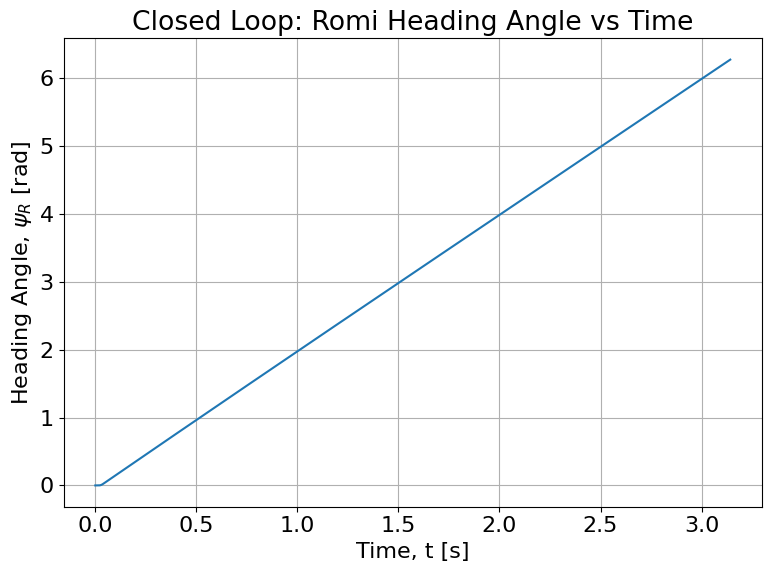

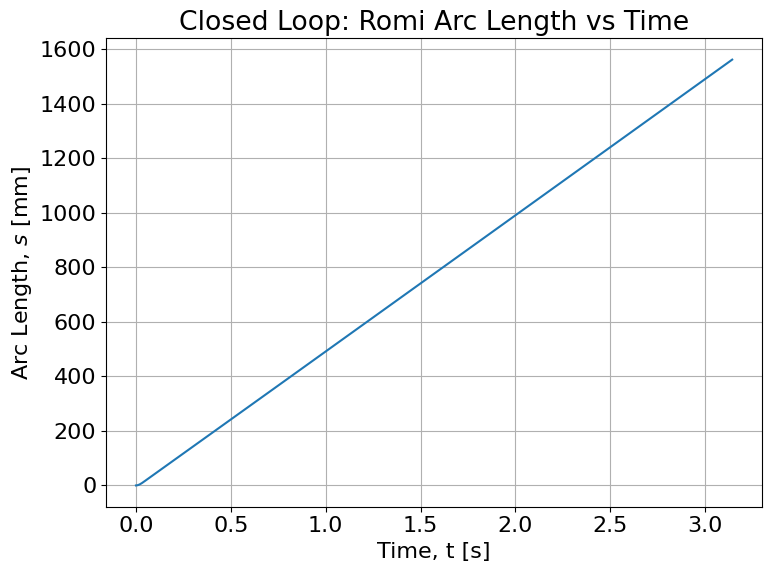

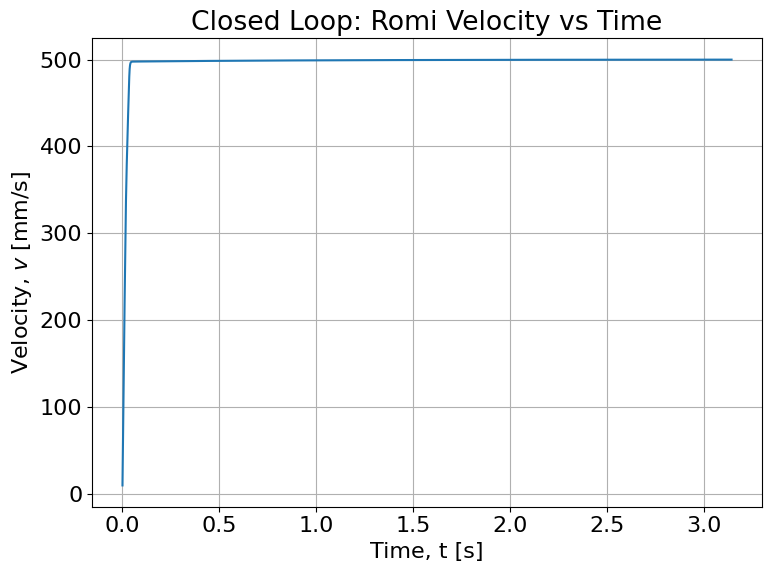

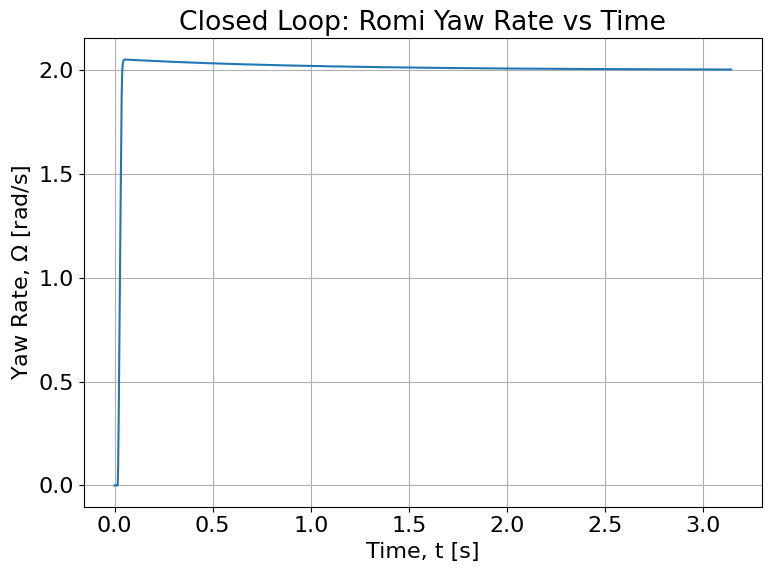

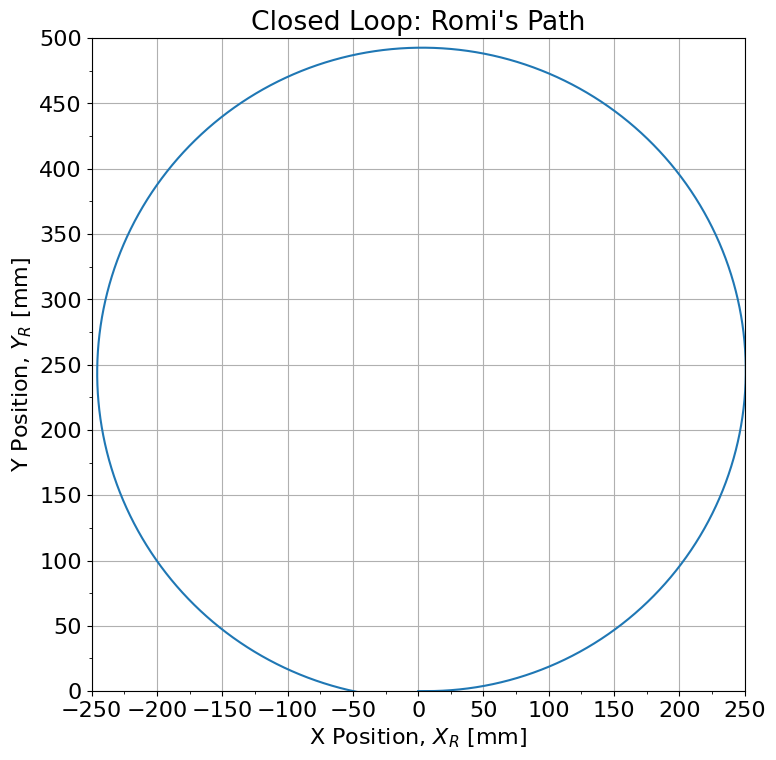

In [601]:
# ------------- Plot Romi X-position vs time -------------
rc('font', **{'size'   : 16})
pyplot.figure(figsize=(8,6))
pyplot.plot(t_CL, y_CL[:,0])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Horizontal Position, $X_R$ [mm/s]')
pyplot.title('Closed Loop: Romi X-position vs Time')
pyplot.grid()
pyplot.tight_layout()

# ------------- Plot Romi Y-position vs time -------------
rc('font', **{'size'   : 16})
pyplot.figure(figsize=(8,6))
pyplot.plot(t_CL, y_CL[:,1])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Vertical Position, $Y_R$ [mm/s]')
pyplot.title('Closed Loop: Romi Y-position vs Time')
pyplot.grid()
pyplot.tight_layout()

# ------------- Plot Romi Heading vs time -------------
rc('font', **{'size'   : 16})
pyplot.figure(figsize=(8,6))
pyplot.plot(t_CL, y_CL[:,2])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Heading Angle, $\psi_R$ [rad]')
pyplot.title('Closed Loop: Romi Heading Angle vs Time')
pyplot.grid()
pyplot.tight_layout()

# ------------- Plot Romi Arc length vs time -------------
rc('font', **{'size'   : 16})
pyplot.figure(figsize=(8,6))
pyplot.plot(t_CL, y_CL[:,3])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Arc Length, $s$ [mm]')
pyplot.title('Closed Loop: Romi Arc Length vs Time')
pyplot.grid()
pyplot.tight_layout()

# ------------- Plot Romi Velocity vs time -------------
rc('font', **{'size'   : 16})
pyplot.figure(figsize=(8,6))
pyplot.plot(t_CL, y_CL[:,4])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Velocity, $v$ [mm/s]')
pyplot.title('Closed Loop: Romi Velocity vs Time')
pyplot.grid()
pyplot.tight_layout()

# ------------- Plot Romi Yaw Rate vs time -------------
rc('font', **{'size'   : 16})
pyplot.figure(figsize=(8,6))
pyplot.plot(t_CL, y_CL[:,5])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Yaw Rate, $\Omega$ [rad/s]')
pyplot.title('Closed Loop: Romi Yaw Rate vs Time')
pyplot.grid()
pyplot.tight_layout()

# ------------- Plot Romi Path -------------
rc('font', **{'size'   : 16})
pyplot.figure(figsize=(8,8))
pyplot.plot(y_CL[:,0], y_CL[:,1])
pyplot.title("Closed Loop: Romi's Path")
pyplot.xlabel('X Position, $X_R$ [mm]')
pyplot.ylabel('Y Position, $Y_R$ [mm]')
pyplot.xlim(-250, 250)   
pyplot.ylim(0, 500)  
ax = pyplot.gca()
ax.xaxis.set_major_locator(MultipleLocator(50))  # major ticks every 50 mm
ax.xaxis.set_minor_locator(MultipleLocator(25))  # minor ticks every 25 mm
ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(25))
ax.set_aspect('equal', adjustable='box')   # preserve data aspect
ax.set_box_aspect(1)                       # make the plotting box square
pyplot.grid()
pyplot.tight_layout()
